In [53]:
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from msrest.authentication import ApiKeyCredentials
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
from azure.storage.blob import BlobServiceClient
from io import BytesIO

## Azure authentication
Don't forget to `az login` in cmd!

In [2]:
keyVaultName = "cvprojectkeyvault"
KVUri = f"https://{keyVaultName}.vault.azure.net"

credential = DefaultAzureCredential()
client = SecretClient(vault_url=KVUri, credential=credential)

In [3]:
PREDICTION_ENDPOINT = 'https://cvprojectcustomvision-prediction.cognitiveservices.azure.com/'
prediction_key = client.get_secret("customvisionpredictionkey").value
prediction_resource_id = "/subscriptions/44e3ab59-824c-408d-b002-013df38d0d7f/resourceGroups/AI_Engineer_Computer_Vision/providers/Microsoft.CognitiveServices/accounts/cvprojectcustomvision-Prediction"

In [4]:
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(PREDICTION_ENDPOINT, prediction_credentials)

In [5]:
predictor.api_version

'3.1'

# Get local files for prediction

In [6]:
local_image_path = '../starter/lighter_test_images/'
project_id = '6f91cbf7-cc1d-4fd5-8048-c87f8b6ba042'
published_name = 'LighterDetectionModel'

In [31]:
def perform_prediction(image_file_name):
    with open(os.path.join (local_image_path,  image_file_name), "rb") as image_contents:
        results = predictor.detect_image(project_id, published_name, image_contents.read())
        # Display the results.
        preds = []
        for prediction in results.predictions:
            preds.append({prediction.tag_name: prediction.probability})
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))
    return preds

In [32]:
file_name = "lighter_test_set_1of5.jpg"

# Perform prediction for one sample image

In [33]:
perform_prediction(file_name)

	Lighter: 92.07%
	Lighter: 44.55%
	Lighter: 33.42%
	Lighter: 26.28%
	Lighter: 2.14%
	Lighter: 1.75%
	Lighter: 1.60%
	Lighter: 1.35%
	Lighter: 1.14%


[{'Lighter': 0.9207476},
 {'Lighter': 0.44547194},
 {'Lighter': 0.33415037},
 {'Lighter': 0.2627891},
 {'Lighter': 0.021372527},
 {'Lighter': 0.017497271},
 {'Lighter': 0.016029954},
 {'Lighter': 0.0135472715},
 {'Lighter': 0.011418909}]

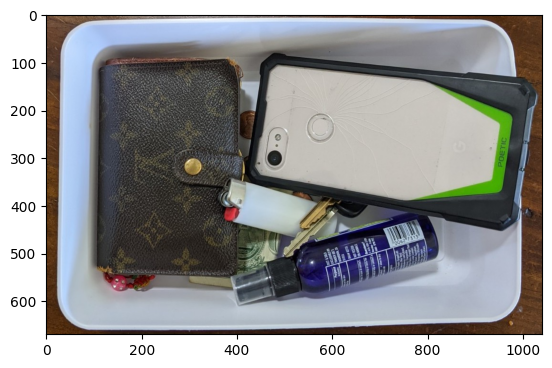

In [34]:
## Checking the Image
with open(os.path.join (local_image_path, file_name), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)

There is a lighter in the image, so the results seems to look ok.  
However, if you check the predicted bounding boxes (in Custom Vision portal quick test, for example), the model actually identified the smartphone and random other stuff as lighters.  
In a real use case, we would need to gather a lot more images and train more iterations.  
We should probably also train the model to identify other objects ("non-lighters") and how to tell them apart.

# Perform prediction for all test images

In [46]:
directory = os.fsencode(local_image_path)

predictions = {}
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg"): 
        print(os.path.join(os.fsdecode(directory), filename))
        pred = perform_prediction(filename)
        predictions[filename] = pred
    else:
        continue

../starter/lighter_test_images/lighter_test_set_1of5.jpg
	Lighter: 92.07%
	Lighter: 44.55%
	Lighter: 33.42%
	Lighter: 26.28%
	Lighter: 2.14%
	Lighter: 1.75%
	Lighter: 1.60%
	Lighter: 1.35%
	Lighter: 1.14%
../starter/lighter_test_images/lighter_test_set_2of5.jpg
	Lighter: 60.53%
	Lighter: 53.82%
	Lighter: 3.16%
	Lighter: 2.50%
	Lighter: 2.22%
../starter/lighter_test_images/lighter_test_set_3of5.jpg
	Lighter: 76.20%
	Lighter: 20.54%
	Lighter: 1.79%
	Lighter: 1.48%
	Lighter: 1.01%
../starter/lighter_test_images/lighter_test_set_4of5.jpg
	Lighter: 85.27%
	Lighter: 12.29%
	Lighter: 8.75%
	Lighter: 1.67%
	Lighter: 1.07%
../starter/lighter_test_images/lighter_test_set_5of5.jpg
	Lighter: 100.00%
	Lighter: 67.01%
	Lighter: 2.60%
	Lighter: 1.80%
	Lighter: 1.23%


In [47]:
predictions

{'lighter_test_set_1of5.jpg': [{'Lighter': 0.9207476},
  {'Lighter': 0.44547194},
  {'Lighter': 0.33415037},
  {'Lighter': 0.2627891},
  {'Lighter': 0.021372527},
  {'Lighter': 0.017497271},
  {'Lighter': 0.016029954},
  {'Lighter': 0.0135472715},
  {'Lighter': 0.011418909}],
 'lighter_test_set_2of5.jpg': [{'Lighter': 0.6053256},
  {'Lighter': 0.5382086},
  {'Lighter': 0.031552315},
  {'Lighter': 0.024985552},
  {'Lighter': 0.022151887}],
 'lighter_test_set_3of5.jpg': [{'Lighter': 0.76195425},
  {'Lighter': 0.20543402},
  {'Lighter': 0.017865121},
  {'Lighter': 0.014849633},
  {'Lighter': 0.0101285875}],
 'lighter_test_set_4of5.jpg': [{'Lighter': 0.85268676},
  {'Lighter': 0.12286106},
  {'Lighter': 0.087518305},
  {'Lighter': 0.016670167},
  {'Lighter': 0.0106859505}],
 'lighter_test_set_5of5.jpg': [{'Lighter': 0.99996424},
  {'Lighter': 0.6701341},
  {'Lighter': 0.0260351},
  {'Lighter': 0.017953128},
  {'Lighter': 0.012282759}]}

In [48]:
df_predictions = pd.DataFrame.from_dict(predictions, orient="index")
df_predictions

,0,1,2,3,4,5,6,7,8
lighter_test_set_1of5.jpg,{'Lighter': 0.9207476},{'Lighter': 0.44547194},{'Lighter': 0.33415037},{'Lighter': 0.2627891},{'Lighter': 0.021372527},{'Lighter': 0.017497271},{'Lighter': 0.016029954},{'Lighter': 0.0135472715},{'Lighter': 0.011418909}
lighter_test_set_2of5.jpg,{'Lighter': 0.6053256},{'Lighter': 0.5382086},{'Lighter': 0.031552315},{'Lighter': 0.024985552},{'Lighter': 0.022151887},None,None,None,None
lighter_test_set_3of5.jpg,{'Lighter': 0.76195425},{'Lighter': 0.20543402},{'Lighter': 0.017865121},{'Lighter': 0.014849633},{'Lighter': 0.0101285875},None,None,None,None
lighter_test_set_4of5.jpg,{'Lighter': 0.85268676},{'Lighter': 0.12286106},{'Lighter': 0.087518305},{'Lighter': 0.016670167},{'Lighter': 0.0106859505},None,None,None,None
lighter_test_set_5of5.jpg,{'Lighter': 0.99996424},{'Lighter': 0.6701341},{'Lighter': 0.0260351},{'Lighter': 0.017953128},{'Lighter': 0.012282759},None,None,None,None


# Store results in Blob storage

In [51]:
account_url = "https://computervisionproject.blob.core.windows.net"
default_credential = DefaultAzureCredential()

# Create the BlobServiceClient object
blob_service_client = BlobServiceClient(account_url, credential=default_credential)

In [55]:
parquet_file = BytesIO()
df_predictions.to_parquet(parquet_file, engine = 'pyarrow')
parquet_file.seek(0)

0

In [56]:
container = 'kiosk'
blob_path = 'lighter_detection/predictions.parquet'
blob_client = blob_service_client.get_blob_client(container = container, blob = blob_path)

In [57]:
blob_client.upload_blob(data = parquet_file)

{'etag': '"0x8DC7D9C1E330FCF"',
 'last_modified': datetime.datetime(2024, 5, 26, 15, 54, 25, tzinfo=datetime.timezone.utc),
 'content_md5': bytearray(b'\xacc\x05\xe3W\xa46\x81\xc1\xf3\n\x8a\x95\xe3\xbfp'),
 'client_request_id': '380ab126-1b78-11ef-a1ae-701ab80a14cc',
 'request_id': '16b8a116-b01e-0019-2384-afe570000000',
 'version': '2024-05-04',
 'version_id': None,
 'date': datetime.datetime(2024, 5, 26, 15, 54, 25, tzinfo=datetime.timezone.utc),
 'request_server_encrypted': True,
 'encryption_key_sha256': None,
 'encryption_scope': None}